# Simulations with Model Violations: Aperiodic

In this set of simulations, we will test FOOOF's performance across power spectra that violate some of the assumptions of the FOOOF model. 

Here, we will explore model violations of the aperiodic components.

In [1]:
import pickle

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, mode

from fooof import FOOOF, FOOOFGroup, fit_fooof_group_3d
from fooof.plts import plot_spectrum
from fooof.sim import gen_power_spectrum, gen_group_power_spectra

In [2]:
# Import project specific (local) custom code
import sys
sys.path.append('../code')
from settings import *
from utils import *
from plts import *

## Settings

In [3]:
# Set plotting style from seaborn
import seaborn as sns
sns.set_style('white')

In [4]:
# Analysis Settings
SAVE_FIG = True
GEN_SIMS = True

In [5]:
# Set helper function for sizing FOOOF plots
from fooof.plts.utils import check_ax
def get_ax():
    return check_ax(None, figsize=(6, 5))

## Example Model Violation Simulation

In this example, we will simulate a power spectrum with a knee, but fit a model in the mode without a knee, to see how much this impacts fitting. 

In [6]:
# Test generate a power spectrum
off_val = 1
kne_val = 10
exp_val = 2.0

ap = [off_val, kne_val, exp_val]
osc = [10, 0.3, 1]
nlv = 0.0

fs, ps = gen_power_spectrum(F_RANGE_LONG, ap, osc, nlv, F_RES)

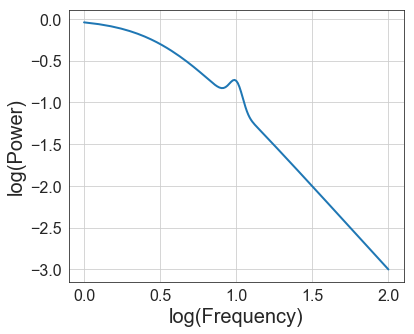

In [7]:
# Plot example simulated power spectrum
plot_spectrum(fs, ps, True, True, ax=get_ax())

In [8]:
# Initialize FOOOF models, with different aperiodic modes
fm1 = FOOOF(aperiodic_mode='fixed')
fm2 = FOOOF(aperiodic_mode='knee')

# Fit models to example simulated spectrum
fm1.fit(fs, ps)
fm2.fit(fs, ps)

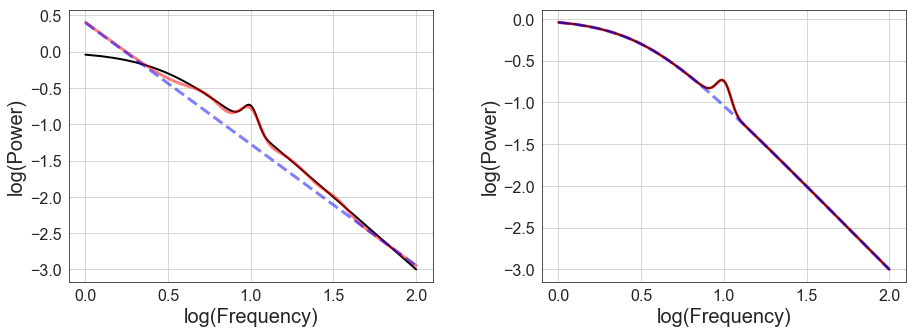

In [9]:
plt_log = True
fig, axes = plt.subplots(1, 2, figsize=[15, 5])

fm1.plot(plt_log=plt_log, add_legend=False, ax=axes[0])
fm2.plot(plt_log=plt_log, add_legend=False, ax=axes[1])

plt.subplots_adjust(wspace=0.3)

In [10]:
# Check how well our example was fit, focusing on the aperiodic exponent
string = ("With a simulated exponent value of {:1.1f}:\n\n"
          "  The fixed mode fit value was:\t {:1.3f}\n"
          "  The knee mode fit value was: \t {:1.3f}")
print(string.format(exp_val,
                    fm1.get_params('aperiodic_params', 'exponent'), 
                    fm2.get_params('aperiodic_params', 'exponent')))

With a simulated exponent value of 2.0:

  The fixed mode fit value was:	 1.674
  The knee mode fit value was: 	 2.001


As we can see above, the estimation of the exponent, when there is a knee in the data, but no knee term in the model, is not a very good estimation. This example suggests that it is quite important for the model to be set with the appropriate mode for aperiodic fitting.

Next we can simulate an expanded set of data, to further explore model fitting in this situation. 

## Simulate Power Spectra

In this set of power spectra, we will simulate across a fixed set of knee values.

For each simulation, we will sample the other aperiodic components, and also add one peak.

We will then parameterize these data in 'fixed' mode - that is, an aperiodic mode inconsistent with the mode that simulated the data - to see how sensitive fit quality is to model assumptions.

In [11]:
# Set the number of power spectra - this is per noise condition
n_psds = 1000

# Set the noise level to use
nlv = 0.025

# Set the knee values to use
knee_vals = [0, 1, 10, 25, 100]

# Use generators to sample peak & aperiodic parameters
peaks = gen_peak_def(1)

# Get the number of values
n_knees = len(knee_vals)
n_freqs = int((F_RANGE_LONG[1] - F_RANGE_LONG[0]) / F_RES + 1)

In [12]:
# Generate or load power spectra
data_name = 'mvap_kne_sims'

if GEN_SIMS:
    
    # Initialize data stores
    psds = np.empty(shape=[n_knees, n_psds, n_freqs])
    sim_params = [None] * n_knees

    # Generate simulated power spectra
    for n_ind, knee in enumerate(knee_vals):
        aps = gen_ap_knee_def(knee)
        freqs, psds[n_ind, :, :], sim_params[n_ind] = \
            gen_group_power_spectra(n_psds, F_RANGE_LONG, aps, peaks, nlv, F_RES)
    
    # Save out generated simulations & parameter definitions
    np.savez(DATA_PATH + data_name + '.npz', freqs, psds)
    with open(DATA_PATH + data_name + '.p', 'wb') as f_obj:
        pickle.dump(sim_params, f_obj)

else:
    
    # Load previously generated simulations & parameter definitions
    temp = np.load(DATA_PATH + data_name + '.npz')
    freqs, psds = temp['arr_0'], temp['arr_1']
    with open(DATA_PATH + data_name + '.p', 'rb') as f_obj:
        sim_params = pickle.load(f_obj)
        
# Check shape
print('n_knees, n_spectra, n_freqs : ', psds.shape)

n_knees, n_spectra, n_freqs :  (5, 1000, 397)


In [13]:
# Extract ground truth values
peak_truths, ap_truths = get_ground_truth(sim_params)

### Fit Power Spectra with FOOOF

In [14]:
# Initialize FOOOFGroup to test with
fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6, min_peak_height=0.1,
                aperiodic_mode='fixed', verbose=False)

# Print out settings used for fitting simulated power spectra
fg.print_settings()

                                                                                                  
                                         FOOOF - SETTINGS                                         
                                                                                                  
                                    Peak Width Limits : [1, 6]                                    
                                     Max Number of Peaks : 6                                      
                                    Minimum Peak Height : 0.1                                     
                                       Peak Threshold: 2.0                                        
                                      Aperiodic Mode : fixed                                      
                                                                                                  


In [15]:
# Fit power spectra - same FOOOF settings across each group of simulated power spectra
fgs = fit_fooof_group_3d(fg, freqs, psds)

### Extract FOOOF fit Data

In [16]:
# Extract data of interest from FOOOF fits
peak_fits, ap_fits, err_fits, r2_fits, n_fit_peaks = get_fit_data(fgs)

In [17]:
# Calculate errors of the aperiodic parameters that were fit
off_errors = calc_errors(ap_truths[:, :, 0], ap_fits[:, :, 0])
exp_errors = calc_errors(ap_truths[:, :, -1], ap_fits[:, :, -1])

In [18]:
# Get count of number of fit peaks as related to simulated knee value
n_peak_counter = count_peak_conditions(n_fit_peaks, knee_vals)

### Check Average Errors & Stats

In [19]:
# Check overall fit quality
temp = r2_fits.flatten()
print('Min/Max R^2: \t{:1.4f} \t{:1.4f}'.format(np.min(temp), np.max(temp)))
print('Median  R^2: \t{:1.4f}'.format(np.median(temp)))

Min/Max R^2: 	0.3927 	0.9992
Median  R^2: 	0.9874


In [20]:
# Collect data together
datas = {
    'OFF' : off_errors,
    'EXP' : exp_errors,
    'ERR' : err_fits,
    'R^2' : r2_fits
}

In [21]:
# Print out the average error for each parameter, across number of peaks
#   Also prints out the average model error and R^2 per peak count
for label, data in datas.items():
    print(label)
    print('\t', np.nanmedian(data, 1))

OFF
	 [0.00612493 0.13675226 0.80028496 1.09476318 1.74606137]
EXP
	 [0.00347381 0.07302195 0.35276037 0.50796514 0.80625797]
ERR
	 [0.01995677 0.02218346 0.03109901 0.03446258 0.03563383]
R^2
	 [0.99695335 0.99542686 0.98267583 0.98174085 0.96432586]


### Create Plots

#### Aperiodic Components

First, lets check how well we do reconstructing the aperiodic parameters that we did fit.

In the plots below we can see that the presence of a knee does impact the fit error of out aperiodic components, and that the degree of this effect scales with the value of the knee. 

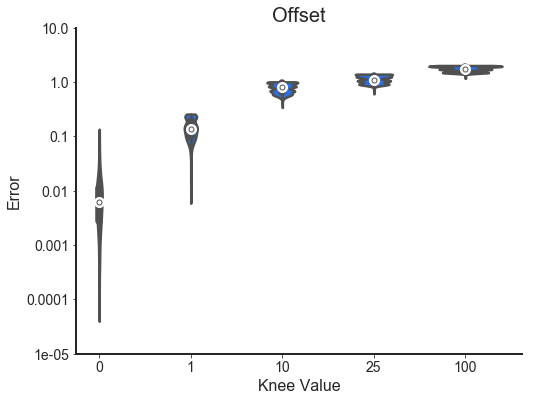

In [22]:
# Multi-peak fitting: plot error of aperiodic offset reconstruction across number of peaks
plot_errors_violin(off_errors, 'Offset', x_axis='knees', plt_log=True)

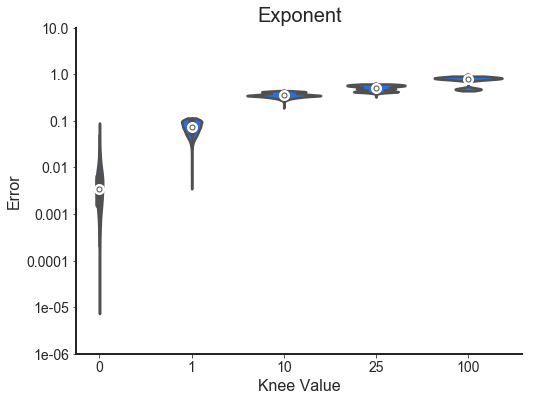

In [23]:
# Multi-peak fitting: plot error of aperiodic offset reconstruction across number of peaks
plot_errors_violin(exp_errors, 'Exponent', x_axis='knees', plt_log=True)

#### Periodic Components

Here, we will check how the peak fitting went, checking in particular how many peaks are fit. 

Note that all spectra were created with a single peak. 

In the plot below, we can see that in all cases with a knee (knee value != 0), the model fits too many peaks.

In [ ]:
# Plot the correspondance between number of simulated peaks & number of fit peaks
plot_n_peaks_bubbles(n_peak_counter, x_label='knee', ms_val=12)

#### Goodness of Fit Measures

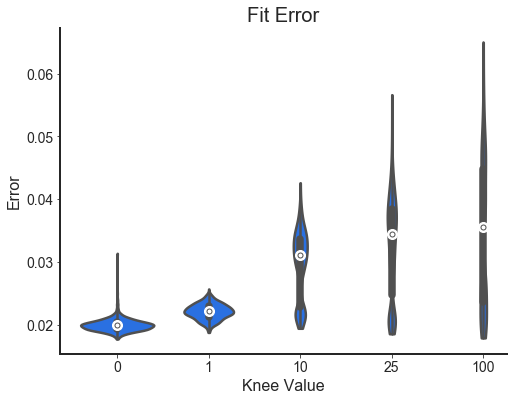

In [25]:
# Multi-peak fitting: plot error levels across number of peaks
plot_errors_violin(err_fits, 'Fit Error',
                   x_axis='knees', plt_log=False)

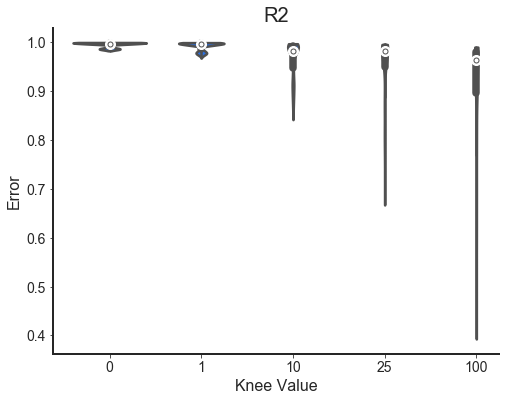

In [26]:
# Multi-peak fitting: plot R^2 levels across number of peaks
plot_errors_violin(r2_fits, 'R2', x_axis='knees', plt_log=False)

### Example FOOOF Fits

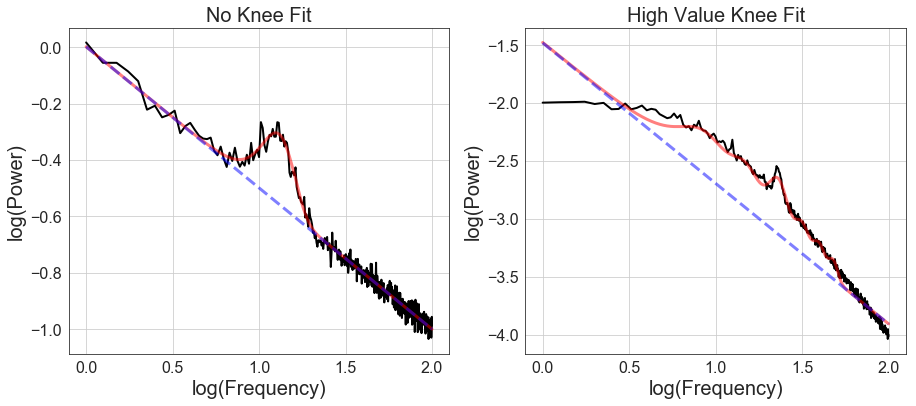

In [44]:
_, axes = plt.subplots(1, 2, figsize=[15, 6])

# Grab example case of no knee
fm = fgs[0].get_fooof(0, True)
fm.plot(plt_log=True, add_legend=False, ax=axes[0])
axes[0].set_title('No Knee Fit', {'fontsize' : 20})

# Grab example case of highest value knee
fm = fgs[-1].get_fooof(0, True)
fm.plot(plt_log=True, add_legend=False, ax=axes[1])
axes[1].set_title('High Value Knee Fit', {'fontsize' : 20});

## Fitting a knee model with no knee

Note that so far we have investigated fitting data with a knee, with a model without a knee. 

Next, let's check if there is an impact of fitting a model with a knee parameter to data without a knee.

To do so, we will run a model fits in 'knee' mode on our set of simulation with a knee value of 0. 

In [57]:
# Initialize a new FOOOFGroup, in 'knee mode'
nk_fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6, min_peak_height=0.1,
                   aperiodic_mode='knee', verbose=False)

# Fit the first set of data, where knee value is 0
nk_fg.fit(freqs, psds[0, :, :])

In [58]:
# Get the fit data
nk_peak_fits, nk_ap_fits, nk_err_fits, nk_r2_fits, nk_n_fit_peaks = get_fit_data([nfg])

# Squeeze because we only have one 'condition' for these sims
nk_peak_fits = np.squeeze(nk_peak_fits)
nk_ap_fits = np.squeeze(nap_fits)
nk_err_fits = np.squeeze(nk_err_fits)
nk_r2_fits = np.squeeze(nk_r2_fits)
nk_n_fit_peaks = np.squeeze(nk_n_fit_peaks)

# Extract the true simulated parameters for the no-knee data condition, used here
nk_ap_truths = ap_truths[0, :, :]

In [59]:
# Calculate errors of the aperiodic parameters that were fit
nk_off_errors = calc_errors(nk_ap_truths[:, 0], nk_ap_fits[:, 0])
nk_exp_errors = calc_errors(nk_ap_truths[:, -1], nk_ap_fits[:, -1])

In [60]:
# Check the goodness of fit measures 
print('Average fit error: \t {:1.3f}'.format(np.mean(nk_err_fits)))
print('Average fit R^2: \t {:1.3f}'.format(np.mean(nk_r2_fits)))

Average fit error: 	 0.020
Average fit R^2: 	 0.995


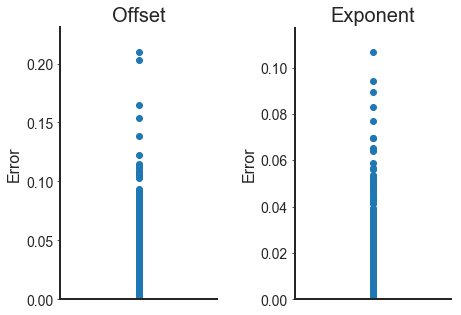

In [61]:
# Check the error off fit offset and exponent values
_, axes = plt.subplots(1, 2, figsize=[7, 5])
plt.subplots_adjust(wspace=0.5)
plot_single_data(nk_off_errors, 'Offset', ax=axes[0])
plot_single_data(nk_exp_errors, 'Exponent', ax=axes[1])

Mean value for knee value: 0.014


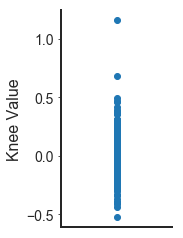

In [62]:
# Check the actual fit knee values in the knee-less data
print('Mean value for knee value: {:1.3f}'.format(
    np.mean(nk_fg.get_params('aperiodic_params', 'knee'))))
plot_single_data(nk_fg.get_params('aperiodic_params', 'knee'), ylabel='Knee Value')

In [71]:
# Check the average number of fit peaks
#   Note: this simulations only
print('The modal number of fit peaks is:\t {:1.0f}'.format(mode(nk_n_fit_peaks).mode[0]))
print('The mean number of fit peaks is:\t {:1.2f}'.format(np.mean(nk_n_fit_peaks)))

The modal number of fit peaks is:	 1
The mean number of fit peaks is:	 1.91


#### Knee Model Fit Conclusion

As we can see above, fitting a model with a knee parameter on data that does not have a knee, as the knee value tends to be fit as approximately 0 (where exactly 0 would be the true parameter value), and the model fit overall does well: with low overall error, well fit aperiodic parameters, and no obvious bias in the number of fit peaks.